In [51]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 15 10:47:54 2021

@author: ryan.robinson

Known issue: fails if a detector is only 1 pixel
"""
import laserbeamtools as lbt
from win32com.client.gencache import EnsureDispatch, EnsureModule
from win32com.client import CastTo, constants
from win32com.client import gencache
import matplotlib.pyplot as plt
import numpy as np

# Notes
#
# The python project and script was tested with the following tools:
#       Python 3.4.3 for Windows (32-bit) (https://www.python.org/downloads/) - Python interpreter
#       Python for Windows Extensions (32-bit, Python 3.4) (http://sourceforge.net/projects/pywin32/) - for COM support
#       Microsoft Visual Studio Express 2013 for Windows Desktop (https://www.visualstudio.com/en-us/products/visual-studio-express-vs.aspx) - easy-to-use IDE
#       Python Tools for Visual Studio (https://pytools.codeplex.com/) - integration into Visual Studio
#
# Note that Visual Studio and Python Tools make development easier, however this python script should should run without either installed.

class PythonStandaloneApplication(object):
    class LicenseException(Exception):
        pass

    class ConnectionException(Exception):
        pass

    class InitializationException(Exception):
        pass

    class SystemNotPresentException(Exception):
        pass

    def __init__(self):
        # make sure the Python wrappers are available for the COM client and
        # interfaces
        gencache.EnsureModule('{EA433010-2BAC-43C4-857C-7AEAC4A8CCE0}', 0, 1, 0)
        gencache.EnsureModule('{F66684D7-AAFE-4A62-9156-FF7A7853F764}', 0, 1, 0)
        # Note - the above can also be accomplished using 'makepy.py' in the
        # following directory:
        #      {PythonEnv}\Lib\site-packages\wind32com\client\
        # Also note that the generate wrappers do not get refreshed when the
        # COM library changes.
        # To refresh the wrappers, you can manually delete everything in the
        # cache directory:
        #	   {PythonEnv}\Lib\site-packages\win32com\gen_py\*.*
        
        self.TheConnection = EnsureDispatch("ZOSAPI.ZOSAPI_Connection")
        if self.TheConnection is None:
            raise PythonStandaloneApplication.ConnectionException("Unable to intialize COM connection to ZOSAPI")

        self.TheApplication = self.TheConnection.CreateNewApplication()
        if self.TheApplication is None:
            raise PythonStandaloneApplication.InitializationException("Unable to acquire ZOSAPI application")

        if self.TheApplication.IsValidLicenseForAPI == False:
            raise PythonStandaloneApplication.LicenseException("License is not valid for ZOSAPI use")

        self.TheSystem = self.TheApplication.PrimarySystem
        if self.TheSystem is None:
            raise PythonStandaloneApplication.SystemNotPresentException("Unable to acquire Primary system")

    def __del__(self):
        if self.TheApplication is not None:
            self.TheApplication.CloseApplication()
            self.TheApplication = None

        self.TheConnection = None

    def OpenFile(self, filepath, saveIfNeeded):
        if self.TheSystem is None:
            raise PythonStandaloneApplication.SystemNotPresentException("Unable to acquire Primary system")
        self.TheSystem.LoadFile(filepath, saveIfNeeded)
    def CloseFile(self, save):
        if self.TheSystem is None:
            raise PythonStandaloneApplication.SystemNotPresentException("Unable to acquire Primary system")
        self.TheSystem.Close(save)

    def SamplesDir(self):
        if self.TheApplication is None:
            raise PythonStandaloneApplication.InitializationException("Unable to acquire ZOSAPI application")

        return self.TheApplication.SamplesDir

    def ExampleConstants(self):
        if self.TheApplication.LicenseStatus is constants.LicenseStatusType_PremiumEdition:
            return "Premium"
        elif self.TheApplication.LicenseStatus is constants.LicenseStatusType_ProfessionalEdition:
            return "Professional"
        elif self.TheApplication.LicenseStatus is constants.LicenseStatusType_StandardEdition:
            return "Standard"
        else:
            return "Invalid"
    
def parseDetector(TheSystem,det):
    """
    Def:
        - Extract detector array and settings
    
    Input:
        - NCE: NCE object
        - det: Detector number
    
    Output:
        - None
        """
    # Get detector total size in pixels
    dsize = TheSystem.NCE.GetDetectorSize(det)
    
    # Get detector dimensions in pixels
    ddims = TheSystem.NCE.GetDetectorDimensions(det)
    x_pixels = ddims[1]
    y_pixels = ddims[2]
    
    # Get detector dimensions in mm
    a = TheSystem.NCE.GetObjectAt(det).GetObjectCell(constants.ObjectColumn_Par1)
    o_x = float(str(a))*2
    b = TheSystem.NCE.GetObjectAt(det).GetObjectCell(constants.ObjectColumn_Par2)
    o_y = float(str(b))*2

    print(o_x)
    print(o_y)
    
    # Read detector values
    
    d = TheSystem.Analyses.New_Analysis(constants.AnalysisIDM_DetectorViewer)
    d_set = d.GetSettings()
    setting = CastTo(d_set, 'IAS_DetectorViewer')
    setting.Detector.SetDetectorNumber(det)
    #setting.ShowAs = constants.DetectorViewerShowAsTypes_FalseColor
    d.ApplyAndWaitForCompletion()
    d_results = d.GetResults()
    results = CastTo(d_results, 'IAR_')
    d_values = results.GetDataGrid(0).Values
    A = np.array(d_values)
    
    return A, det, 1000*o_x/x_pixels, 1000*o_y/y_pixels

C:\Users\ryan.robinson\Documents\Zemax Projects\ble_v2\module_only_cyl_temp.zmx
Running ray trace...
Ray trace finished.
Total Number of Objects in System: 19
40.0
40.0
1.0
1.0


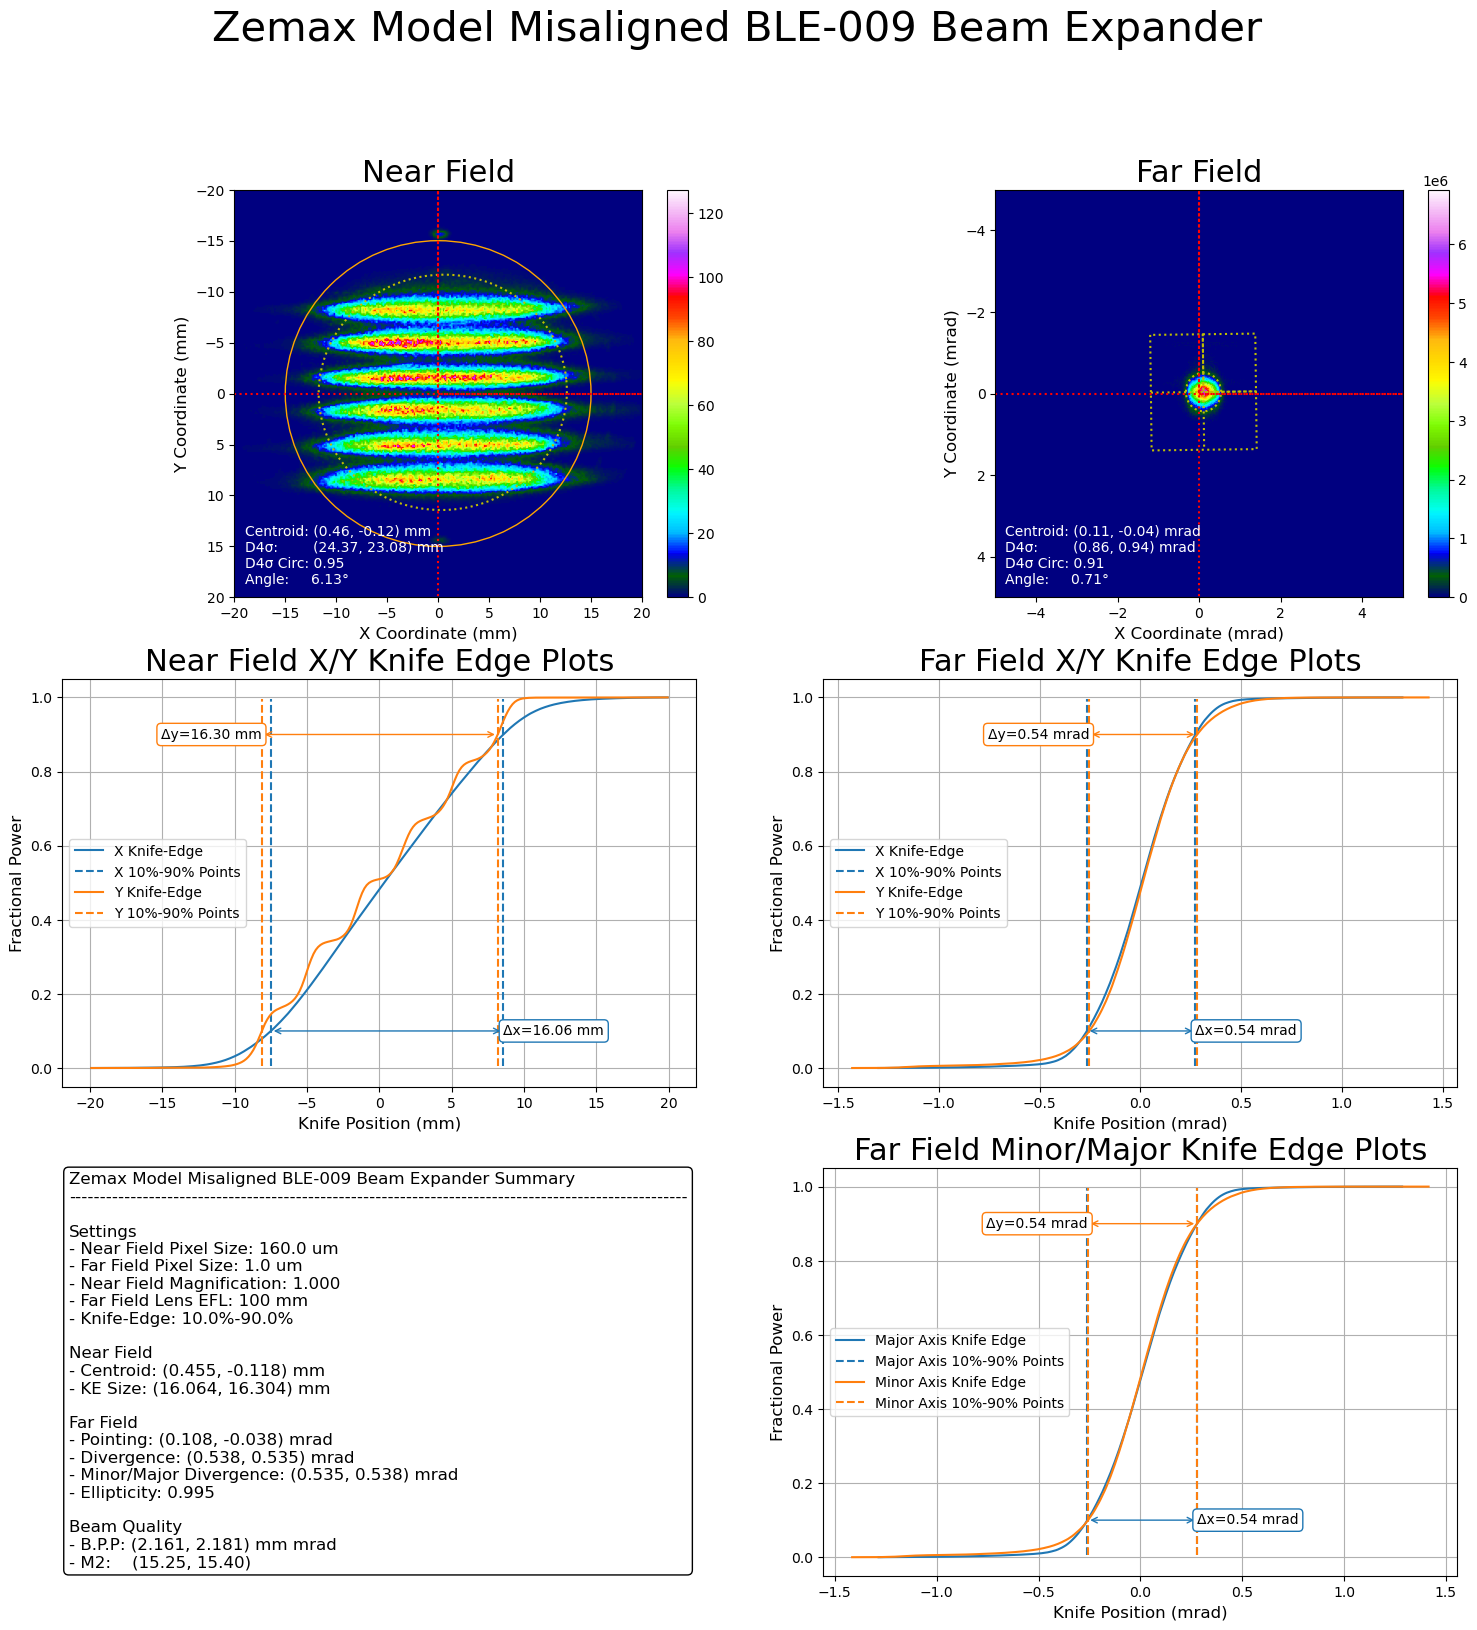

In [180]:
# -*- coding: utf-8 -*-

zosapi = PythonStandaloneApplication()

TheSystem = zosapi.TheSystem
testFile = r'C:\Users\ryan.robinson\Documents\Zemax Projects\ble_v2\module_only_cyl_temp.zmx'

# LOAD FILE
TheSystem.LoadFile(testFile, False)
print(TheSystem.SystemFile)

# RUN RAYTRACE
print('Running ray trace...')
NSCRayTrace = TheSystem.Tools.OpenNSCRayTrace()
NSCRayTrace.SplitNSCRays = True
NSCRayTrace.ScatterNSCRays = False
NSCRayTrace.UsePolarization = True
NSCRayTrace.IgnoreErrors = True
NSCRayTrace.SaveRays = False
NSCRayTrace.ClearDetectors(0)
baseTool = CastTo(NSCRayTrace, 'ISystemTool')
baseTool.RunAndWaitForCompletion()
baseTool.Close()
print('Ray trace finished.')

objNum = TheSystem.NCE.NumberOfObjects
print('Total Number of Objects in System: {}'.format(objNum))




# TypeName = TheSystem.NCE.GetObjectAt(14).TypeName
nf, nf_det, nfpp, _ = parseDetector(TheSystem,16)

# TypeName = TheSystem.NCE.GetObjectAt(16).TypeName
ff, ff_det, ffpp, _ = parseDetector(TheSystem,19)

# Run analysis method
results = lbt.near_and_far_profiles(nf,
                                    ff, 
                                    title='Zemax Model Misaligned BLE-009 Beam Expander', 
                                    ff_lens=100.0,
                                    ff_units='mrad',
                                    ff_pixel_size=ffpp,
                                    nf_pixel_size=nfpp,
                                    nf_mag=1.0, 
                                    nf_scale_down=1000, 
                                    nf_units='mm',
                                    show_plt=True,
                                    save=True,
                                    ff_int_crop=True,
                                    kep=[0.10,0.90])

del zosapi
zosapi = None

# ZEMAX MEASUREMENT CLASS DEFINITION

## Zemax Measurement Class

In [56]:
import time

class ZemaxMeasurement:
    def __init__(self, zemaxFile):
        """
        SETUP THE ZOS API
        """
        # ZOS API STUFF
        print("Connecting to ZOS API...")
        self.zosapi = PythonStandaloneApplication()
        self.TheSystem = self.zosapi.TheSystem

        # LOAD FILE
        print("Loading ZEMAX file...")
        self.TheSystem.LoadFile(zemaxFile, False)
        print(self.TheSystem.SystemFile)    
    
        # RAYTRACE SETTINGS
        self.NSCRayTrace = self.TheSystem.Tools.OpenNSCRayTrace()
        self.NSCRayTrace.SplitNSCRays = True #self.splitVar.get()
        self.NSCRayTrace.ScatterNSCRays = False #self.scatterVar.get()
        self.NSCRayTrace.UsePolarization = True #self.polVar.get()
        self.NSCRayTrace.IgnoreErrors = True #self.ignoreErrVar.get()
        self.NSCRayTrace.SaveRays = False
        self.NSCRayTrace.ClearDetectors(0)
        
        # FIND TOTAL NUMBER OF OBJECTS IN THE SYSTEM
        self.objNum = self.TheSystem.NCE.NumberOfObjects
        print('Total Number of Objects in System: {}'.format(self.objNum))
       
        self.BP = None
        return
    
    def xPos(self, x, obj = 6):
        """
        CHANGE THE X POSITION OF OBJECT
        """
        TheNCE = self.TheSystem.NCE
        FAC = TheNCE.GetObjectAt(obj)
        FAC.XPosition = x
        return


    def yPos(self, y, obj = 6):
        """
        CHANGE THE Y POSITION OF OBJECT
        """
        TheNCE = self.TheSystem.NCE
        FAC = TheNCE.GetObjectAt(obj)
        FAC.YPosition = y
        return
    
    def zPos(self, z, obj = 6):
        """
        CHANGE THE Z POSITION OF OBJECT
        """
        TheNCE = self.TheSystem.NCE
        FAC = TheNCE.GetObjectAt(obj)
        FAC.ZPosition = z
        return
    
    def xTilt(self, xt, obj = 6):
        TheNCE = self.TheSystem.NCE
        FAC = TheNCE.GetObjectAt(obj)
        FAC.TiltAboutX = xt
        return
    
    def yTilt(self, yt, obj = 6):
        TheNCE = self.TheSystem.NCE
        FAC = TheNCE.GetObjectAt(obj)
        FAC.TiltAboutY = yt
        return
    
    def zTilt(self, zt, obj = 6):
        TheNCE = self.TheSystem.NCE
        FAC = TheNCE.GetObjectAt(obj)
        FAC.TiltAboutZ = zt
        return
       
    def rayTrace(self):
        """
        RUN A RAYTRACE
        """
        # RAYTRACE SETTINGS
        # print('Running ray trace...')
  
        self.NSCRayTrace.ClearDetectors(0)
        
        # RUN RAYTRACE
        self.baseTool = CastTo(self.NSCRayTrace, 'ISystemTool')
        self.baseTool.RunAndWaitForCompletion()
        # self.baseTool.Close()
        time.sleep(1)
        # print('Ray trace finished.')
        
        return

    def parseDetector(self, det):
        """
        Def:
            - Extract detector array and settings
        
        Input:
            - NCE: NCE object
            - det: Detector number
        
        Output:
            - None
            """
        # Get detector total size in pixels
        # dsize = self.TheSystem.NCE.GetDetectorSize(det)
        
        # Get detector dimensions in pixels
        ddims = self.TheSystem.NCE.GetDetectorDimensions(det)
        x_pixels = ddims[1]
        y_pixels = ddims[2]
        
        # Get detector dimensions in mm
        a = self.TheSystem.NCE.GetObjectAt(det).GetObjectCell(constants.ObjectColumn_Par1)
        o_x = float(str(a))*2
        b = self.TheSystem.NCE.GetObjectAt(det).GetObjectCell(constants.ObjectColumn_Par2)
        o_y = float(str(b))*2
        
        # Read detector values
        d = self.TheSystem.Analyses.New_Analysis(constants.AnalysisIDM_DetectorViewer)
        d_set = d.GetSettings()
        setting = CastTo(d_set, 'IAS_DetectorViewer')
        setting.Detector.SetDetectorNumber(det)
        #setting.ShowAs = constants.DetectorViewerShowAsTypes_FalseColor
        d.ApplyAndWaitForCompletion()
        d_results = d.GetResults()
        results = CastTo(d_results, 'IAR_')
        d_values = results.GetDataGrid(0).Values
        A = np.array(d_values)
    
        return A, det, 1000*o_x/x_pixels, 1000*o_y/y_pixels

    def parseSurf(self, detector):
        """
        Def:
            - Extract detector array and settings

        Input:
            - NCE: NCE object
            - det: Detector number

        Output:
            - None
        """
        flux_bool_return, total_flux = self.TheSystem.NCE.GetDetectorData(detector, 0, 0)  # Object Number=4, Pix=0 & Data=0 (total flux)
        print(flux_bool_return)
        print(total_flux)
        return total_flux

    def close(self):
        """
        DELETE ZOS API
        """
        # DELETE ZOS API OBJECTS
        self.baseTool.Close()
        del self.zosapi
        self.zosapi = None
        return






## Scanning A Detector Window In Z

In [169]:
import numpy as np

testFile = r'C:\Users\ryan.robinson\Documents\Zemax Projects\ble_v2\module_only_cyl_temp.zmx'
zm = ZemaxMeasurement(testFile)

# Define scan range
zs = np.linspace(-1, 1, 41)

n = 1

obj = 18+n

all_results = []

for z in zs:
    zm.zPos(z, obj=19)

    zm.rayTrace()
    
    # TypeName = TheSystem.NCE.GetObjectAt(14).TypeName
    nf, nf_det, nfpp, _ = zm.parseDetector(16)

    # TypeName = TheSystem.NCE.GetObjectAt(16).TypeName
    ff, ff_det, ffpp, _ = zm.parseDetector(19)

    # Run analysis method
    results = lbt.near_and_far_profiles(nf,
                                        ff, 
                                        title='Zemax Beam Expander Model {}'.format(z), 
                                        ff_lens=100.0,
                                        ff_units='mrad',
                                        ff_pixel_size=ffpp,
                                        nf_pixel_size=nfpp,
                                        nf_mag=1.0, 
                                        nf_scale_down=1000, 
                                        nf_units='mm',
                                        show_plt=False,
                                        save=False,
                                        kep=[0.10,0.90])
    all_results.append(results)

zm.close()

Connecting to ZOS API...
Loading ZEMAX file...
C:\Users\ryan.robinson\Documents\Zemax Projects\ble_v2\module_only_cyl_temp.zmx
Total Number of Objects in System: 19


## Viewing Results From Detector Window Scan

[0.45521307901215735, -0.11802992862759609, 16.064541429145255, 16.304261100392598, 0.1600062711235113, -0.04074883162060772, 1.7263564799995215, 1.635456600854788, 0.947291587850874, 1.727024514524138, 1.6359957946209556, 6.9332812986064205, 6.6662278596742555, 48.948965968161325, 47.06356868930024]
[1.72702451 1.64894869 1.57165336 1.49530443 1.42024868 1.34522949
 1.27184984 1.19963161 1.12814684 1.05830389 0.98246561 0.92043291
 0.86121429 0.80255133 0.74620265 0.6940172  0.64640186 0.60517703
 0.57254874 0.55042695 0.53810609 0.53451145 0.53859453 0.54963528
 0.56922067 0.59843471 0.63760624 0.6854573  0.74324921 0.81461941
 0.86512991 0.92526519 0.9917615  1.06145378 1.13338605 1.2059329
 1.28008448 1.35520446 1.43020163 1.50575115 1.58136303]
[1.63599579 1.56277861 1.49056064 1.41868911 1.34772003 1.27768272
 1.20890744 1.14088058 1.0744972  1.01232062 0.96505913 0.89660534
 0.82752605 0.76782542 0.71338764 0.6646694  0.62216574 0.58669869
 0.55970298 0.54221782 0.53526204 0.540

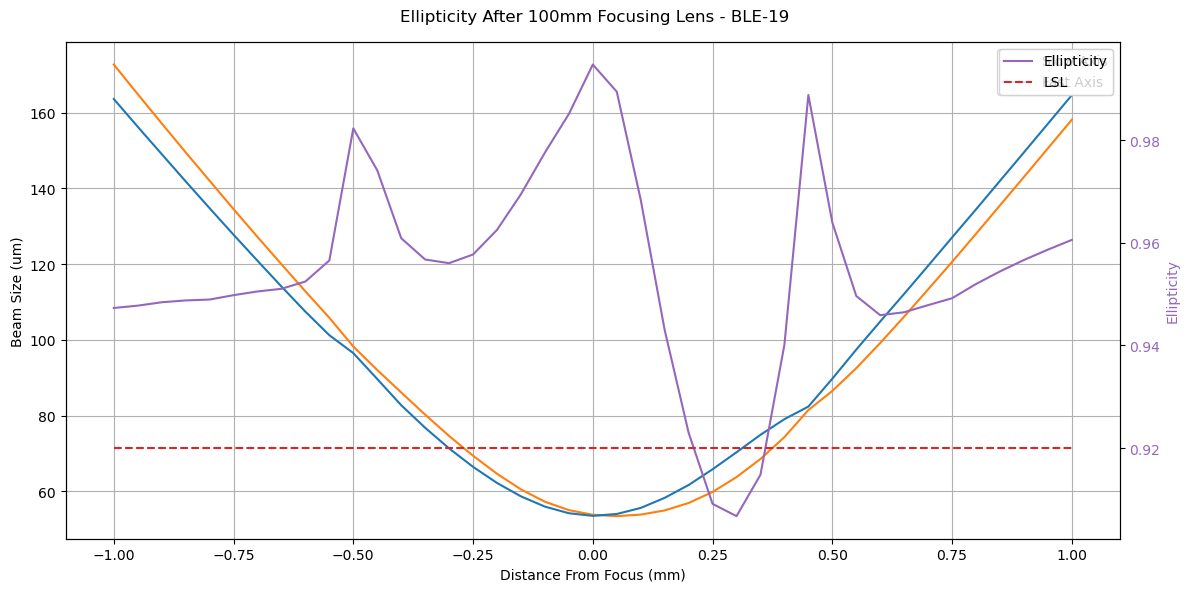

In [170]:
import matplotlib.pyplot as plt

sad = []
fad = []
print(all_results[0])

for result in all_results:
    sad.append(result[9]) # Slow axis divergence
    fad.append(result[10]) # Fast axis divergence

sad = np.asarray(sad)
fad = np.asarray(fad)

print(sad)
print(fad)

# plt.figure(1, figsize=(12,6))
# plt.plot(zs, sad*100, label="Slow Axis")
# plt.plot(zs, fad*100, label="Fast Axis")
# plt.xlabel('Distance From Focus (mm)')
# plt.ylabel('Beam Size (um)')
# plt.title('Depth of Circularity')
# plt.grid('on')
# plt.legend()


el = np.full_like(sad, fill_value=0)
for i,v in enumerate(sad):
    if sad[i] > fad[i]:
        el[i] = fad[i]/sad[i]
    else:
        el[i] = sad[i]/fad[i]


fig, ax1 = plt.subplots(1, figsize=(12,6))

fig.suptitle('Ellipticity After 100mm Focusing Lens - BLE-19')

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Beam Size (um)')
ax1.plot(zs, sad*100, color='tab:orange', label='Slow Axis')
ax1.plot(zs, fad*100, color='tab:blue', label='Fast Axis')
ax1.tick_params(axis='y')
ax1.set_xlabel('Distance From Focus (mm)')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:purple'
ax2.set_ylabel('Ellipticity', color=color)  # we already handled the x-label with ax1
ax2.plot(zs, el, color=color, label='Ellipticity')
ax2.plot([-1,1], [0.92, 0.92], color='tab:red', linestyle='--', label='LSL')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend()
ax2.legend()
ax1.grid('on')
plt.show()

[0.45521307901215735, -0.11802992862759609, 16.064541429145255, 16.304261100392598, 0.1600062711235113, -0.04074883162060772, 1.7263564799995215, 1.635456600854788, 0.947291587850874, 1.727024514524138, 1.6359957946209556, 6.9332812986064205, 6.6662278596742555, 48.948965968161325, 47.06356868930024]
[1.72702451 1.64894869 1.57165336 1.49530443 1.42024868 1.34522949
 1.27184984 1.19963161 1.12814684 1.05830389 0.98246561 0.92043291
 0.86121429 0.80255133 0.74620265 0.6940172  0.64640186 0.60517703
 0.57254874 0.55042695 0.53810609 0.53451145 0.53859453 0.54963528
 0.56922067 0.59843471 0.63760624 0.6854573  0.74324921 0.81461941
 0.86512991 0.92526519 0.9917615  1.06145378 1.13338605 1.2059329
 1.28008448 1.35520446 1.43020163 1.50575115 1.58136303]
[1.63599579 1.56277861 1.49056064 1.41868911 1.34772003 1.27768272
 1.20890744 1.14088058 1.0744972  1.01232062 0.96505913 0.89660534
 0.82752605 0.76782542 0.71338764 0.6646694  0.62216574 0.58669869
 0.55970298 0.54221782 0.53526204 0.540

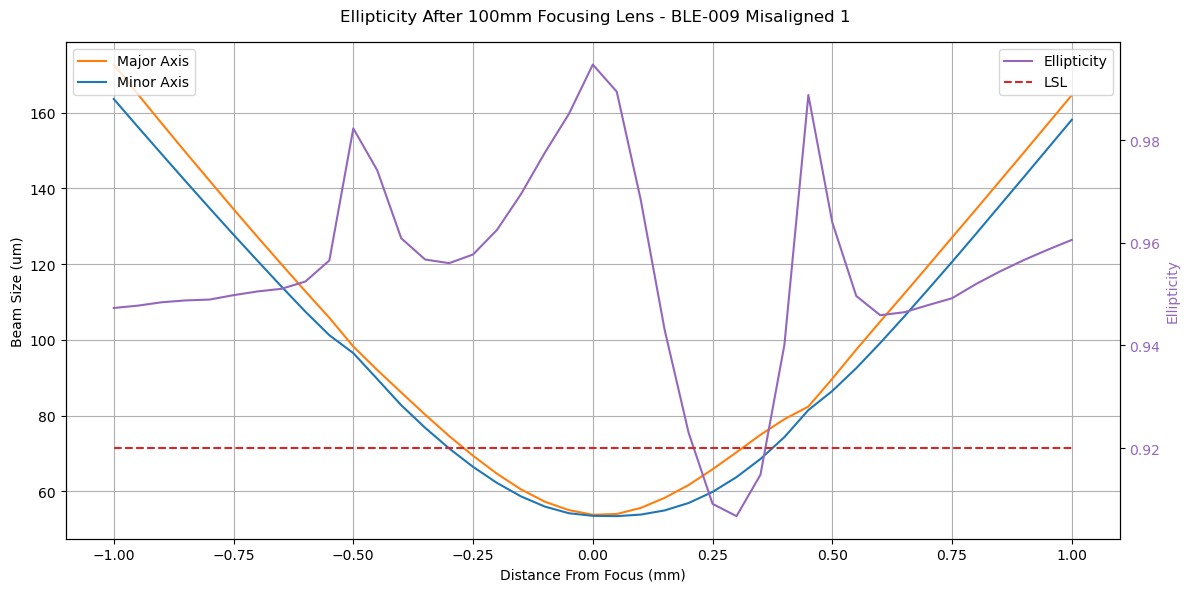

In [172]:
import matplotlib.pyplot as plt

sad = []
fad = []
print(all_results[0])

# all_results2 = all_results

for result in all_results:
    sad.append(result[9]) # Slow axis divergence
    fad.append(result[10]) # Fast axis divergence

sad = np.asarray(sad)
fad = np.asarray(fad)

print(sad)
print(fad)

# plt.figure(1, figsize=(12,6))
# plt.plot(zs, sad*100, label="Slow Axis")
# plt.plot(zs, fad*100, label="Fast Axis")
# plt.xlabel('Distance From Focus (mm)')
# plt.ylabel('Beam Size (um)')
# plt.title('Depth of Circularity')
# plt.grid('on')
# plt.legend()


el = np.full_like(sad, fill_value=0)
ma = np.full_like(sad, fill_value=0)
mi = np.full_like(sad, fill_value=0)

for i,v in enumerate(sad):
    if sad[i] > fad[i]:
        el[i] = fad[i]/sad[i]
        ma[i] = sad[i]
        mi[i] = fad[i]
    else:
        el[i] = sad[i]/fad[i]
        mi[i] = sad[i]
        ma[i] = fad[i]

fig, ax1 = plt.subplots(1, figsize=(12,6))

fig.suptitle('Ellipticity After 100mm Focusing Lens - BLE-009 Misaligned 1')

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Beam Size (um)')
ax1.plot(zs, ma*100, color='tab:orange', label='Major Axis')
ax1.plot(zs, mi*100, color='tab:blue', label='Minor Axis')
ax1.tick_params(axis='y')
ax1.set_xlabel('Distance From Focus (mm)')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:purple'
ax2.set_ylabel('Ellipticity', color=color)  # we already handled the x-label with ax1
ax2.plot(zs, el, color=color, label='Ellipticity')
ax2.plot([-1,1], [0.92, 0.92], color='tab:red', linestyle='--', label='LSL')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid('on')
plt.show()